# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Цель и актуальность исследования
Цель исследования - определить какие критерии и в какой степени влияют на стоимость жилой недвижимости (на примере квартир в Санкт-Петербурге и Ленинградской области), каким критериями определяется срок продажи квартиры, а также разработать метод вычисления аномальных квартир (с неестественной стоимостью или другими параметрами.

### План исследования
* [Изучение общей информации файла](#bullet_1)
* [Предобработка данных](#bullet_2)
* [Добавление рассчетных показателей](#bullet_3)
* [Исследовательский анализ данных](#bullet_4)
    * [Анализ общей информации](#bullet_5)
    * [Очистка таблицы от аномально низких или высоких значений](#bullet_6)
    * [Исследование факторов, влияющих на цену квартиры](#bullet_7)
    * [Самые популярные населённые пункты](#bullet_8)
    * [Недвижимость в центре Санкт-Петербурга](#bullet_9)
* [Общий вывод](#bullet_10)  

<a id="bullet_1"></a>

## Загрузка данных и обзор общей информации

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
url = 'https://drive.google.com/file/d/1rgmO_N7wmnJ8E2d9pDLTwxSGbZeq9bUb/view?usp=sharing'
url2 = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

In [3]:
df = pd.read_csv(url2, sep = '\t')

In [4]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Прочитали файл с данными, и так как данные были разделены не привычным способом, задали дополнительный параметр sep. 
Кроме того, сразу видно, что прежде чем анализировать данные, необходимо предобработать данные:
* изменить формат данных на целочисленные для таких столбцов как: _last_price, floors_total, balcony, airports_nearest, cityCenters_nearest, parks_around3000, ponds_around3000, days_exposition, parks_nearest, ponds_nearest_. Связано это с тем, что для показателей расстояния для нас не так важна информация о сантиметрах, а для количественных значений (вроде количества парков в округе) - дробных значений не может быть.
* выяснить природу пропусков в ряде столбцов, и принять решение каким образом их заполнить
* изменить названия некоторых столбцов (_cityCenters_nearest_)
* скорректировать данные представленные в столбце _first_day_exposition_ - так как, на первый взгляд, информация о времени не зафиксированна, а чтение таблицы усложняет.

Изучим общую информацию о данных.    

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В представленной таблице 23699 записей, но очень много пропусков - скорректируем их (или примем решение оставить) в следующей части. Кроме того, видно что формат данных столбца _first_day_exposition_ нужно будет привести к формату даты.

<a id='bullet_2'></a>

## Предобработка данных

Для начала скорректируем названия столбцов: 

In [6]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [7]:
df.rename(columns={'is_apartment':'apartment', 'airports_nearest':'airports_distance', 
                   'cityCenters_nearest':'city_center_distance', 'parks_around3000':'parks_around_3000', 
                  'parks_nearest':'parks_distance', 'ponds_around3000':'ponds_around_3000', 'ponds_nearest':'ponds_distance'}, inplace=True)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,...,kitchen_area,balcony,locality_name,airports_distance,city_center_distance,parks_around_3000,parks_distance,ponds_around_3000,ponds_distance,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Изменим тип данных столбца _first_day_exposition_ на тип даты. И уберем нулевые значения времени , применив метод округления даты до 1 дня. Такие изменения позволят нам в дальнейшем вычленять отдельные элементы даты (например год размещения объявления), а округление сделает столбец более читабельным.

In [8]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df['first_day_exposition'] = df['first_day_exposition'].dt.round('1d')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,...,kitchen_area,balcony,locality_name,airports_distance,city_center_distance,parks_around_3000,parks_distance,ponds_around_3000,ponds_distance,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Теперьознакомимся с каждым столбцом в отдельности, чтобы убедится, что информация полная или вычислить значения, необходимые к кореектировке. Изучим какое количество фотографий люди обычно публикуют. 

In [9]:
df['total_images'].unique()

array([20,  7, 10,  0,  2,  6,  5, 18,  9,  1, 16, 11,  8, 12, 13,  3, 15,
       17, 14, 19, 32,  4, 35, 39, 23, 21, 27, 30, 24, 25, 28, 31, 22, 29,
       26, 50, 42, 37], dtype=int64)

Проверим есть ли отсутсвующие значения в столбце стоимости _last_price_.

In [10]:
df['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Отсутсвующих значений нет. Но оченьбольшой разбег цен: от 12 тыс.рублей до 763 млн.рублей. Кроме того, разница между средним и медианным значениями существенна. Вернемся к аналитике этих параметров в следующей главе.
А пока изучим информацию об общей площади в столбце _total_area_

In [11]:
df['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

Пропусков в столбце общей площади нет. Средняя квартира площадью 60 кв.м. Что выглядит вполне разумным. Привлекают к себе внимание объекты с минимальным значением площади: 12 кв.м. (на такой площади не может расположиться целая квартира, возможно речь идет о продаже комнаты), и объект с площадью 900 кв.м.

Рассмотрим информацию о количестве комнат в продаваемых квартирах

In [12]:
df['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64

Мы видим классические объявления 1-4 комнаты, и единичные обьявления с 15-19 комнатами. Но на данном этапе мы занимаемся поиском пропусков или дубликатов.

Выявлены объявления, в которых количество комнат = 0. Такое возможно в двух вариантах: 
* а) это действительно так, потому что это квартира - студия, или апартаменты или свободной планировки; 
* б) в реальности это не так, но 0 заполнены пропуски. 

Проверим это предположение: сделаем срез где количество комнат = 0, и не указано True хотябы в одном из столбцов: студия, апартаменты и свободная планировка.

In [13]:
len(df.query('rooms==0 and (studio!=True or apartment!=True or open_plan!=True)'))

197

В результате в нашу выборку попали все те же 197 записей. Пока воспринимаем эти значения как пропуски. Попробуем разобраться с ними далее

Перейдем к поиску пропусков в значении высота потолков. Ранее, мы уже выяснили, что из 23699 записей только 14504 имеют значения, то есть пропусков много. Обычно высота потолков в квартирах стандартная и колеблется от 2,5 до 3,5 метров. Проверим это предположение, построив гистограмму по данному показателю. 

[Text(0.5, 0, 'высота потолков, м'),
 Text(0, 0.5, 'кол-во объявлений'),
 Text(0.5, 1.0, 'Гистограмма высоты потолков')]

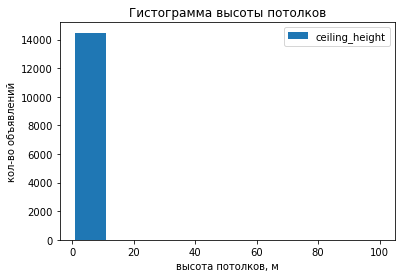

In [14]:
ax = df.plot(kind='hist', y='ceiling_height')
ax.set(xlabel='высота потолков, м', ylabel='кол-во объявлений', title='Гистограмма высоты потолков')

Гистограмма показывает нам, что подавляющее большинство значений сконцентрированно где-то между 0 и 10 метрами, однако есть и уникальные значения вроде 100 метров. Однако нас интересует некая стандартная высота потолков поэтому посмотрим внимательнее именно на выборку, которая сконцентрировалась между 0 и 10.

[Text(0.5, 0, 'высота потолков, м'),
 Text(0, 0.5, 'кол-во объявлений'),
 Text(0.5, 1.0, 'Гистограмма высоты потолков от 2 до 5 метров')]

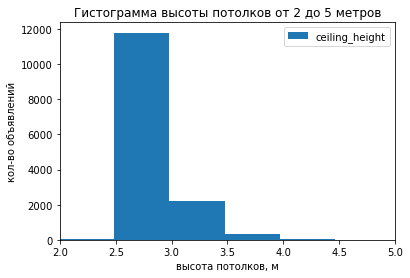

In [15]:
ax = df.plot(kind='hist', y='ceiling_height', xlim=(2, 5), figsize=(6,4), bins=200)
ax.set(xlabel='высота потолков, м', ylabel='кол-во объявлений', title='Гистограмма высоты потолков от 2 до 5 метров')

Наше предположение подтвердилось: большинство квартир со стандртной высотой потолков: от 2,5 до 3-3,5 метров. Поэтому пропуски в столбце _ceiling_height_ заполним медианным значением.  

In [16]:
df['ceiling_height'].fillna(df['ceiling_height'].median(), inplace=True)

В нашей выборке есть квартиры, где пропущены значения жилой площади и/или кухни. Обычно это очень важные параметры и их стараются указать в объявлении о квартире. Однако, пропуски могут быть логичными, если например: 
* а) речь идет о помещении на этапе черновой отделки - когда границы комнат не размечены (то есть и посчитать жилую площадь пока не возможно), 
* б) или если квартира студия - разделить площадь на жилую и кухню также не представляется возможным, 
* в) апартаменты (в значении указанном, для целей данного исследования) - в таких типах недвижимости кухни может не быть совсем. 

Чтобы подтвердить или опровергнуть наше предположение для начала посмотрим на значения в соответствующих булевых столбцах. 

In [17]:
df['studio'].unique()

array([False,  True])

In [18]:
df['open_plan'].unique()

array([False,  True])

In [19]:
df['apartment'].unique()

array([nan, False, True], dtype=object)

In [20]:
df['apartment'].value_counts()

False    2725
True       50
Name: apartment, dtype: int64

Предварительная оценка показыват нам, что в столбцах _studio_ и _open_plan_ пропусков нет, а вот в столбце _apartment_ значения есть лишь в небольшом количестве записей - остальное NaN.

Возвращаясь к вопросу об отсутсвии данных о жилой площади и площади кухни, произведем следующее исследование: 
* так как ранее мы уже проверили, что в столбце общая площадь пропусков нет, то считать что вся строка не валидна мы не будем.
* пропуски в столбце жилая площадь мы заполним медианным значением, предварительно сгруппировав по количеству комнат. То есть для 2-комнатных квартир заполним медианным значением по 2-комнатным квартирам и т.д.
* предварительно посчитаем коэффициент корреляции между количеством комнат и жилой площадью, чтобы убедиться что наш метод замещения пропусков подходит

In [21]:
print(df['living_area'].corr(df['rooms']))

0.8459774567888756


Взаимосвязь между жилой площадью и количеством комнат довольно высока - коэффициент корреляции превышает 0.85, поэтому выбранный метод заполнения пропусков можно считать правомерным.

In [22]:
df['living_area'] = df.groupby('rooms')['living_area'].transform(lambda x: x.fillna(x.median()))

In [23]:
df['living_area'].isnull().sum()

0

Изучим полноту информации о наличие балкона.

In [24]:
df['balcony'].isnull().sum()

11519

In [25]:
df['balcony'] = df['balcony'].fillna(value = '0')

Было выяснено, что в 11519 случаях из почти 24000 наблюдений информации о наличии балкона нет. Такие пропуски мы заполним значением 0, предполагая, что когда балкон есть продавец обязательно это указывает, а пустое значение в данном случае - это признако отсутсвия балкона.

Изучим какие локации представлены в нашем исследовании. Насколько полно представлена информация.

In [26]:
df['locality_name'].isnull().sum()

49

Пропусков относительно немного, но они есть. К сожалению, мы не сможем с точностью восстановить название населенного пункта по другим косвенным признакам записи, поэтому такие пропуски мы заменим просто на пустую ячейку. 

In [27]:
df['locality_name'] = df['locality_name'].fillna(value = '')

In [28]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,...,kitchen_area,balcony,locality_name,airports_distance,city_center_distance,parks_around_3000,parks_distance,ponds_around_3000,ponds_distance,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,NaN,...,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,NaN,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,45.0,9,NaN,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Очистим названия населенных пунктов от вспомогательных слов (деревня, поселок и т.д.), потому как для целей нашего исследования, совершенно не принципиально деревня это или поселок, но наличие таких слов пораждает дубликаты. 

In [29]:
locality_replace_values = ['деревня', 'поселок', 'посёлок','городской', 'городского типа', 'садовое товарищество', 'село',
                          'садоводческое некоммерческое товарищество', 'при железнодорожной станции', 'коттеджный', '\s+' ]

In [30]:
for i in locality_replace_values:
    df['locality_name'] = df['locality_name'].str.replace(i, '')

In [31]:
df['locality_name'].value_counts().head(15)

Санкт-Петербург    15721
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
Пушкин               369
Колпино              338
Парголово            327
Гатчина              307
Выборг               237
Петергоф             201
Сестрорецк           183
КрасноеСело          178
НовоеДевяткино       144
Сертолово            142
Name: locality_name, dtype: int64

Теперь выглядит более читабельно, и кроме того, ушли дублирующиеся названия.

Рассмотрим пропуски в столбце расстояние до аэропорта. 

In [32]:
df['airports_distance'].isnull().sum()

5542

In [33]:
locality_airport = df[df['airports_distance'].isnull()]

In [34]:
len(locality_airport['locality_name'].value_counts())

290

 Мы выяснили что в нашем столбце пропущено 5542 значения. Посчитали, что значения не указаны для 290 населенных пунктов. Отметим, что для данного исследования, вероятно аэропортом считается Пулково. Обработаем пропуски, следуя логике:
* для пропусков в самом Санкт-Петербурге пропуски заменим медианным значением расстояния до аэропорта внутри СПб. 
* для населенных пунктов с количеством объявлений более 50 составим словарь, куда включим справочную информацию, взятую с яндекс-карт. И заменим пропуски, в соответсвии с этим словарем. 


In [35]:
spb_airp_dist_median = df.query('locality_name == "Санкт-Петербург"').pivot_table(
    index='locality_name', values='airports_distance', aggfunc='median')
spb_airp_dist_median

,airports_distance
locality_name,
Санкт-Петербург,26757.5


Медианное значение расстояния до аэропорта внутри Санкт-Петербурга составило чуть более 26.5 км.

In [36]:
airport_dict = {'Мурино':42200, 'Всеволожск':47900, 'Гатчина':30700, 'Выборг':154000, 
                'Кудрово':25400, 'НовоеДевяткино':44900, 'Сертолово':61700, 'Кириши':154000, 'Сланцы':182000, 
                'Волхов':140000, 'Тосно':50000, 'Кингисепп':129000, 'Никольское':39300, 'Коммунар':38900, 'СосновыйБор':94300,
               'Кировск':53100, 'Отрадное':43100, 'Бугры':48000, 'Приозерск':174000, 'Старая':34500, 
                'Янино-1':29700, 'Шлиссельбург':56300, 'Луга':131000, 'Тихвин':225000, 'Тельмана':31000, 'Рощино':82900, 
                'Волосово':76500, 'Романовка':51200, 'мениСвердлова':30600, 'Кузьмоловский':58600, 'Мга':66200, 
                'Сиверский':60400, 'Новоселье':22300, 'Ивангород':151000, 'Сясьстрой':145000, 'Щеглово':54100, 
               'НовыйСвет':33600, 'Вырица':55800, 'Синявино':53400, 'Санкт-Петербург':spb_airp_dist_median}

In [37]:
df['airports_distance'] = df['airports_distance'].fillna(df['locality_name'].apply(lambda x: airport_dict.get(x)))

На этом этапе предположим о причинах возникновения таких пропусков. Для этого вспомним процесс размещения подобного объявления - хозяин квартиры никогда сам не высчитывает расстояние до аэропорта, а если и укзывает в тексте, то цифры указываются "на глаз"). Такие точные цифры (как в представленной таблице) вероятно появились за счет того, что хозяин на карте указывает местонахождение своей недвижимости. Поэтому пропуски появились в тот момент, когда хозяин не обозначил свой дом на карте, а просто вручную вбил адрес. Аналогичная причина пропусков в столбцах с информаией о парках и прудах.

Мы восстановили вручную, то что могла автоматически посчитать яндекс-карта. Но по прежнему остались пропуски для населенных пунктов с небольшим количеством объявлений. Пропуски для таких населенных пунктов заменим медианным значением расстояния до аэропорта.

In [38]:
df['airports_distance'] = df['airports_distance'].fillna(lambda x: x.median())

In [39]:
df['airports_distance'].isnull().sum()

0

Восстановим пропуски данных в информации о расстоянии до центра города.

In [40]:
df['city_center_distance'].isnull().sum()

5519

Не заполнено 5519 значений. Центром города ялвяется центр Санкт - Петербурга. Таким образом, заполним пропуски, в соответсвии с логикой: все пропуски для локации 'Санкт-Петербург' заполним медианным значением по Санкт-Петербургу (переменная _city_center_spb_median_). Все остальные пропуски заполним медианным значением расстояния до центра города всех населенных пунктов, кроме Санкт-Петербурга (переменная _city_center_no_spb_median_).

In [41]:
city_center_spb = df.loc[df['locality_name'] == 'Санкт-Петербург']
city_center_spb_median = city_center_spb['city_center_distance'].median()
city_center_spb_median

12244.5

In [42]:
city_center_no_spb = df.loc[df['locality_name'] != 'Санкт-Петербург']
city_center_no_spb_median = city_center_no_spb['city_center_distance'].median()
city_center_no_spb_median

30308.5

In [43]:
df.loc[(df['locality_name'] == 'Санкт-Петербург') & (
    df['city_center_distance'].isnull()), 'city_center_distance'] = city_center_spb_median

In [44]:
df.loc[(df['locality_name'] != 'Санкт-Петербург') & (
    df['city_center_distance'].isnull()), 'city_center_distance'] = city_center_no_spb_median

In [45]:
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,...,kitchen_area,balcony,locality_name,airports_distance,city_center_distance,parks_around_3000,parks_distance,ponds_around_3000,ponds_distance,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,NaN,...,25.00,0,Санкт-Петербург,18863,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.60,1,NaN,...,11.00,2,Шушары,12817,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.30,4,NaN,...,8.30,0,Санкт-Петербург,21741,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,45.00,9,NaN,...,NaN,0,Санкт-Петербург,28098,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,NaN,...,41.00,0,Санкт-Петербург,31856,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.40,5,NaN,...,9.10,0,Янино-1,29700,30308.5,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02,1,2.65,26.0,10.60,6,NaN,...,14.40,1,Парголово,52996,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18,2,2.65,24.0,30.50,22,NaN,...,18.90,2,Санкт-Петербург,23982,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23,1,2.65,27.0,15.43,26,NaN,...,8.81,0,Мурино,42200,30308.5,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,NaN,...,6.50,2,Санкт-Петербург,50898,15008.0,0.0,NaN,0.0,NaN,289.0


Изучим количество пропусков в столбцах с информацией о ближайших парках и прудах. 

In [46]:
df[['parks_around_3000', 'parks_distance', 'ponds_around_3000', 'ponds_distance']].isnull().sum()

parks_around_3000     5518
parks_distance       15620
ponds_around_3000     5518
ponds_distance       14589
dtype: int64

In [47]:
df[['parks_around_3000', 'ponds_around_3000']] = df[['parks_around_3000', 'ponds_around_3000']].fillna(value = 0)

In [48]:
df[['parks_distance', 'ponds_distance']] = df[['parks_distance', 'ponds_distance']].fillna(value = 0)

Пропусков очень много. Мы заменили их на 0, так как восстановить реальные цифры не представляется возможным, а информация не в первом приоритете.

In [49]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,...,kitchen_area,balcony,locality_name,airports_distance,city_center_distance,parks_around_3000,parks_distance,ponds_around_3000,ponds_distance,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.0,0,Санкт-Петербург,18863,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,NaN,...,11.0,2,Шушары,12817,18603.0,0.0,0.0,0.0,0.0,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,NaN,...,8.3,0,Санкт-Петербург,21741,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,45.0,9,NaN,...,NaN,0,Санкт-Петербург,28098,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.0,0,Санкт-Петербург,31856,8098.0,2.0,112.0,1.0,48.0,121.0


Изучим полноту представления информации об общем количестве этажей.

In [50]:
df['floors_total'].isnull().sum()

86

Небольшое количество пропусков все же есть. Заполним эти пропуски значением этажа этой квартиры, имея в виду, что весь дом не может быть ниже этажа конкретной квартиры, а сколько этажей сверху нее - нам установить не удастся. К сожалению, такой подход в дальнейшем исказит результаты разбивки на категории и "искусственно" завысит количество последних этажей. Однако, так как количество от общей выборки не большое, примем это искажение.

In [51]:
df['floors_total'] = df['floors_total'].fillna(value = df['floor'])
df['floors_total'].head(20)

0     16.0
1     11.0
2      5.0
3     14.0
4     14.0
5     12.0
6     26.0
7     24.0
8     27.0
9      9.0
10    12.0
11     5.0
12     5.0
13     5.0
14     6.0
15    14.0
16     5.0
17    17.0
18     5.0
19    16.0
Name: floors_total, dtype: float64

Ознакомимся с площадями кухонь. В выборку также добавим булевые столбцы (студия, апартаменты, открытая планировка), возможно будет выявлена какая-то зависимость.

In [52]:
df[['rooms', 'apartment', 'studio', 'open_plan', 'kitchen_area']].head(10)

,rooms,apartment,studio,open_plan,kitchen_area
0,3,NaN,False,False,25.00
1,1,NaN,False,False,11.00
2,2,NaN,False,False,8.30
3,3,NaN,False,False,NaN
4,2,NaN,False,False,41.00
5,1,NaN,False,False,9.10
6,1,NaN,False,False,14.40
7,2,NaN,False,False,18.90
8,1,NaN,False,False,8.81
9,3,NaN,False,False,6.50


In [53]:
print(df['kitchen_area'].corr(df['rooms']))

0.26994485416385755


In [54]:
print(df['kitchen_area'].corr(df['total_area']))

0.6091211711198313


In [55]:
df['kitchen_area'] = df.groupby('rooms')['kitchen_area'].transform(lambda x: x.fillna(x.median()))

In [56]:
df['apartment'] = df['apartment'].fillna(value = False)

Пропуски по площади кухонь заполнили медианным значением, соответствующим количесву комнат, а пропуски в столбце _apartment_ заполнили значением False.

Мы очистили нашу таблицу от пропусков. 
Теперь изменим на целочисленный тип данных информацию в следующих столбцах ( в скобках приведена причина смены типа данных): цена (нам не важна информация о копейках), балкон (не бывает 1.5 балкона), скорость продажи (часть дня для нас роли не играет), общее количество этажей (не бывает долей), расстояние до центра города или парка или пруда( для расстояний в метрах доли не принципиальны).

In [57]:
df[['last_price', 'balcony', 'floors_total', 'city_center_distance', 'parks_around_3000', 'parks_distance', 'ponds_around_3000', 'ponds_distance']] = df[['last_price', 'balcony', 'floors_total', 'city_center_distance', 'parks_around_3000', 'parks_distance', 'ponds_around_3000', 'ponds_distance']].astype('int')

In [58]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,...,kitchen_area,balcony,locality_name,airports_distance,city_center_distance,parks_around_3000,parks_distance,ponds_around_3000,ponds_distance,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,NaN
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,11.0,2,Шушары,12817,18603,0,0,0,0,81.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,45.0,9,False,...,9.5,0,Санкт-Петербург,28098,6800,2,84,3,234,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121.0


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int32         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   apartment             23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23502 non-null  float64       
 13  balcony         

### Общий вывод:

Таблица подготовлена для дальнейшего анализа. Были вычислены дубликаты в названиях населенных пунктов. 
Кроме того, были заполнены пропуски: там, где это возможно, информация была восстановлена, там где информацию логически дополнить не возможно - были оставлены пустые ячейки.

 <a id='bullet_3'></a>

### Расчет недостающих данных

Добавим в новый столбец _price_per_sqmeter_ информацию о стоимости 1 квадратного метра ( отношение цены квартиры к общей площади)

In [60]:
df['price_per_sqmeter'] = df['last_price'] / df['total_area']
df['price_per_sqmeter'] = df['price_per_sqmeter'].astype('int')

Добавим в таблицу новые столбцы _year_exposition_, _month_exposition_, _weekday_exposition_. В которые поместим данные: год, месяц и день недели размещения объявления соответственно.

In [61]:
df['year_exposition'] = df['first_day_exposition'].dt.year

In [62]:
df['month_exposition'] = df['first_day_exposition'].dt.month

In [63]:
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday

Посчитаем долю жилой площади и долю кухни в общей площади квартиры. Результаты округли до двух знаков после точки.

In [64]:
df['living_area_share'] = df['living_area'] / df['total_area']
df['living_area_share'] = df['living_area_share'].round(decimals = 2)

In [65]:
df['kitchen_area_share'] = df['kitchen_area'] / df['total_area']
df['kitchen_area_share'] = df['kitchen_area_share'].round(decimals = 2)

Разобьем этажи на категории: первый, последний, высокий (с 9 этажа и выше, но не последний), средний (до 9 этажа, кроме первого).

In [66]:
def floor_cat(floor, floors_total):
    if floor == 1:
        return 'первый'
    if (floors_total - floor) == 0:
        return 'последний'
    if floors_total > floor >= 9:
        return 'высокий'
    if 1 < floor < 9: 
        return 'средний'

df['floor_category'] = df.apply(lambda x: floor_cat(x['floor'], x['floors_total']), axis=1)

В столбце _price_per_km_ мы посчитаем условную стоимость каждого километра удаленности от центра (отношение цены к расстоянию до центра города в километрах).

In [67]:
df['price_per_km'] = df['last_price'] / (df['city_center_distance'] / 1000)
df['price_per_km'] = df['price_per_km'].astype('int')

In [68]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,...,ponds_distance,days_exposition,price_per_sqmeter,year_exposition,month_exposition,weekday_exposition,living_area_share,kitchen_area_share,floor_category,price_per_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,755,NaN,120370,2019,3,3,0.47,0.23,средний,811080
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,0,81.0,82920,2018,12,1,0.46,0.27,первый,180078
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,574,558.0,92785,2015,8,3,0.61,0.15,средний,372927
3,0,64900000,159.0,2015-07-24,3,2.65,14,45.0,9,False,...,234,424.0,408176,2015,7,4,0.28,0.06,высокий,9544117
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,48,121.0,100000,2018,6,1,0.32,0.41,высокий,1234872


Вывод: вспомогательные столбцы добавлены.

<a id='bullet_4'></a>

## Исследовательский анализ данных

__Изучим общую информацию__ <a id='bullet_5'></a>

Так как в дальнейшем нам придется построить несколько гистограмм по разным параметрам, напишем функцию _frequency_, которая будет принимать показатель, рассчитывать границы нормального размаха (в нашем случае Q1-3QR и Q3+3QR), и строить гистограмму в пределах нормального размаха.
Построим гистограмму общей площади квартир.

In [69]:
def frequency (data, xname, yname, full_name, bins, money, color):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    x_limit_min = q1 - 3 * iqr
    x_lim_max = q3 + 3 * iqr
    ax = data.plot(kind='hist', grid=True, xlim=(0, x_lim_max), bins=bins, color=color)
    ax.set(xlabel=xname, ylabel=yname, title=full_name)
    if money == True:
        ax.ticklabel_format(axis='x', scilimits=(6,6))

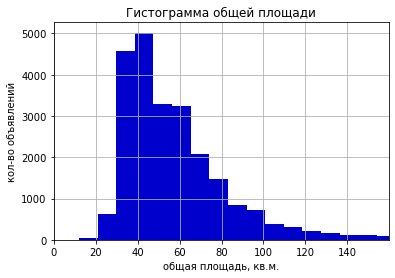

In [70]:
frequency (df['total_area'], 'общая площадь, кв.м.', 'кол-во объявлений', 'Гистограмма общей площади', 100, False, "mediumblue")

Больше всего квартир с площадью от 30 до 60 кв.м. Это близко к медиане общей площади квартир. В прошлой главе этот показатель был рассчитан и составил 52 кв.метра. Есть небольшое количество необычных значений с площадью до 30 квадратных метров.
в остальном распределение выглядит достаточно предсказуемо: чем больше площадь, тем реже предложения.  
Кроме прочего наша гистограмма позволяет нам выявить редкие, выбивающиеся из ряда значенй записи - это квартиры общей площадью более 160 кв.м

Построим гистограмму цены продажи.

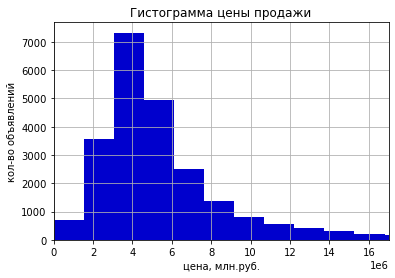

In [71]:
frequency (df['last_price'], 'цена, млн.руб.', 'кол-во объявлений', 'Гистограмма цены продажи', 500, True, "mediumblue")

Больше всего квартир (около 12.5 тысяч) представлено в ценовом диапазоне от 3 до 6 млн.рублей. Если наложить на самую популярную стоимость самую популярную площадь, то получится, что самая популярная квартира площадью 45 кв. метров стоит около 5 млн. рублей.  
Обратим внимание, на верхнюю границу цены, которую можно считать стандартной или приемлмой - она на уровне 17 млн.рублей. 

Изучим количество комнат.

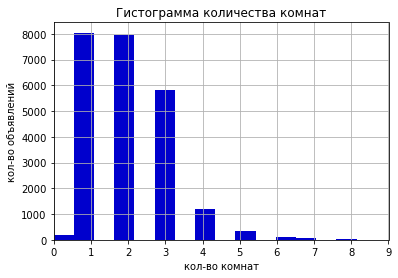

In [72]:
frequency (df['rooms'], 'кол-во комнат', 'кол-во объявлений', 'Гистограмма количества комнат', 35, False, "mediumblue")

Большая часть объявлений (2/3 выборки) касается квартир с 1-2 комнатами. А общее количество предложений классических квартир (1-4 комнаты) составляет более 90%. 
Квартиры с количеством комнат более 8 можно считать аномальными

Узнаем а как же распределяется высота потолков. 

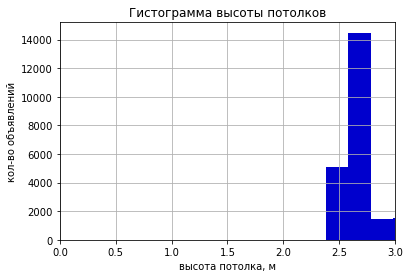

In [73]:
frequency (df['ceiling_height'], 'высота потолка, м', 'кол-во объявлений', 'Гистограмма высоты потолков', 500, False, "mediumblue")

В выборке мы видели, что на продажу была выставлена недвижимость с высотой потолка 100 метров. Но в наш график такие значения не попали, так как следуя логике построения гистограмм (описанной ранее) потолки выше 3м. для нашей выборки считаются редкими, аномальными. 
Аномальные значения (особенно выше логичных цифр - вроде 3.5м) - это либо намеренное введение в заблуждение автором объявления, либо опечатка, которая моглабы искажать картину.

Тем не менее, большинство людей живет в достаточно стандартных квартирах с потолками 2.7 метра. Меньше людей, но все же продают квартиры с высотой потолка 2,5 или 3 метра. Общий диапазон 2.5 - 3 метра.

Большинство квартир имеют очень стандартные потолки: в промежутке от 2,4 до 3 метров. 

Ознакомимся как долго объявления находятся на сайте.

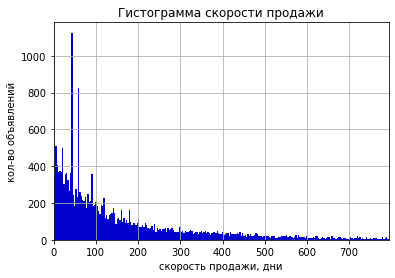

In [74]:
frequency (df['days_exposition'], 'скорость продажи, дни', 'кол-во объявлений', 'Гистограмма скорости продажи', 500, False, "mediumblue")

На первый взгляд, подавляющее большинство квартир продается  в течение 5 месяцев, и примерно 20% квартир продаются несколько дольше: от 150 до 500 дней. Выясним какие продажи можно считать скорыми, а какие затянутыми.

Большинство квартир продаются в первые 75 дней. Будем считать это хорошим, стандартным сроком продажи. 
Данные о продажах после 100 дней говорят о том, что это происходит с относительно небольшим количеством квартир, а продажи более 1 года стремятся к нулю.
Чтобы выявить какую продажу можно считать необычайно скорой, посмотрим гистограмму продаж между 0 и 50 днями подробнее. 

[Text(0.5, 0, 'скорость продажи, дни'),
 Text(0, 0.5, 'кол-во объявлений'),
 Text(0.5, 1.0, 'Гистограмма скорости продажи до 50 дней')]

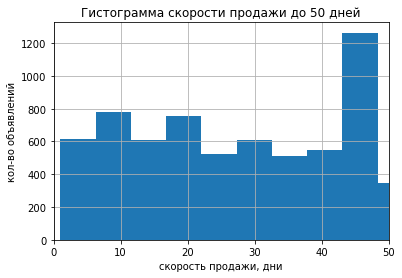

In [75]:
ax = df['days_exposition'].plot(kind='hist', xlim=(0,50), bins = 300, grid=True)
ax.set(xlabel='скорость продажи, дни', ylabel='кол-во объявлений', title='Гистограмма скорости продажи до 50 дней')

Гистограмма отражает, что промежуток от 0 до 40 дней - быстрая продажа
Рассчитаем среднее и медианное значение срока продаж для всей выборки.

In [76]:
days_exp_mean = df['days_exposition'].mean()
days_exp_mean

180.88863436982163

In [77]:
days_exp_median = df['days_exposition'].median()
days_exp_median

95.0

В среднем квартира продается за 5 месяцев, а медианное значение составило 74 дня. Большая разница между средним и медианным значением сообщает о неоднородности данных, то есть есть аномально большие значения, что и было отражено в гистограмме скорости продаж.

__Очистим таблицу от аномально высоких или низких значений__<a id='bullet_6'></a>

Гистограмма скорости продаж показывает, что продажи около 600 дней - это редкость, но все же после 600 дней значения все же есть. Если мы примем записи о продаже больше 600 дней как аномальные (скорее всего квартира была продана, но обьявление вовремя не убрали с сайта) и отбросим их для дальнейшего анализа, посчитаем какую долю наблюдей придется отбросить.

In [78]:
len(df.query('days_exposition  > 600')) / len(df)

0.05055065614582894

In [79]:
len(df.query('days_exposition == 0')) / len(df)

0.0

18% объявлений - это те, квартиры по которым еще не проданы, или находящиеся на сайте более 600 дней. 18 

Проверим как изменились среднее и медианное значение длительности продажи, после того, как были 

In [80]:
df_600days = df.query('0 < days_exposition <=600')

In [81]:
days_600_mean = df_600days['days_exposition'].mean()
days_600_mean

139.17531055900622

In [82]:
days_600_median = df_600days['days_exposition'].median()
days_600_median

89.00000000000001

Среднее значение составило 139 дней, в то время как медиана срока продаж составляет 89 дней. Медианное значение возрасло (с 74 дней до 89), так как из выборки были вычищены значения = 0 - это квартиры, которые в прошлой главе мы приняли как еще не проданные, то среднее значение сильно зависило от больших аномальных значений, поэтому и изменилось со 157 дней до 139.

Чтобы получить таблицу данных, очещенную от аномальных искажающих значений, оставим в нашей таблице только те объявления, где высота потолков не превышает 3 метра, а количество комнат не превышает 8. 
Посмотрим насколько сильно сократиласьнаша выборка после применения этих условий.

In [83]:
df_ceiling_days = df_600days.query('ceiling_height <= 3')
len(df_ceiling_days)

18279

In [84]:
df_clean = df_ceiling_days.query('rooms <= 8')
len(df_clean)

18273

Нам пришлось очистить большое количество значений, но выборка в 18273 записей является достаточной для дальнейшей аналитики, поэтому условия для отделения аномальных значений выставленны корректно.

__Изучим факторы, от которых зависит цена квартиры__<a id='bullet_7'></a>

Построим диаграмму рассеяния, и изучим насколько сильно цена квартиры зависит от общей площади.

In [85]:
price_q1 = df_clean['last_price'].quantile(0.25)
price_q3 = df_clean['last_price'].quantile(0.75)
price_iqr = price_q3 - price_q1
price_n_min = price_q1 - 3 * price_iqr
price_n_max = price_q3 + 5 * price_iqr

In [86]:
def price_factor (column, style, sizex, sizey, xname, yname, full_name):
    q1 = df_clean[column].quantile(0.25)
    q3 = df_clean[column].quantile(0.75)
    iqr = q3 - q1
    x_limit_min = q1 - 3 * iqr
    x_lim_max = q3 + 3 * iqr
    ax = df_clean.plot(x=column, y='last_price', kind=style, xlim=(0, x_lim_max), ylim=(price_n_min, price_n_max), alpha=0.09, figsize=(sizex, sizey))
    ax.set(xlabel=xname, ylabel=yname, title=full_name)
    ax.ticklabel_format(axis='y', scilimits=(6,6))

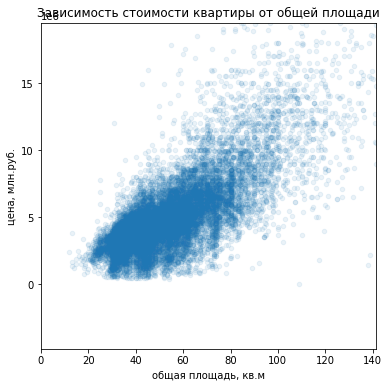

In [87]:
price_factor('total_area', 'scatter', 6, 6, 'общая площадь, кв.м','цена, млн.руб.', 'Зависимость стоимости квартиры от общей площади')

Прослеживается завсимость между стоимостью квартиры и общей площадью. В конце главы просчитаем коэффициент корреляции между этими показателями.

Исследуем как цена квартиры зависит от жилой площади.

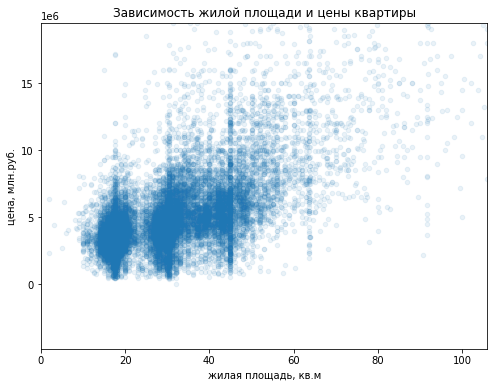

In [88]:
price_factor('living_area', 'scatter', 8, 6, 'жилая площадь, кв.м','цена, млн.руб.', 'Зависимость жилой площади и цены квартиры')

Зависимость цены от жилой площади наблюдается для квартир более 45 кв.метров.

Можно ли считать количество комнат существенным фактором в ценообразовании? Исследуем этот вопрос далее

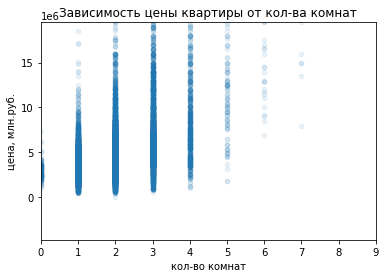

In [89]:
price_factor('rooms', 'scatter', 6, 4, 'кол-во комнат','цена, млн.руб.', 'Зависимость цены квартиры от кол-ва комнат')

Очень интересно распределились цены квартир, в зависимости от их комнатности: до 3 комнат (включительно) с возрастанием количества комнат напрямую возрастает и цена, для квартир 3-4 комнат - относительно равные цены, но для квартир 5-8 комнат цена идет на снижение (в сравнении с 3-4 комнатными). Так например, 6-комнатную квартиру можно купить по цене 2-комнатной. 
Такая разница в ценах между 1-комнатными и 2-комнатными квартирами связана с тем, что 1-комнатная квартира подходит для 1 -2 жителей. Но с увеличением количества членов семьи(например рождение ребенка) требуется не только большая площадь, но и разделение ее на зоны (комнаты). Поэтому разница в планировке между 1-комнатной и 2-комнатной квартирой критична, и поэтому цена так резко изменяется. 

Что же касается квартир 3-5 комнат. То такие квартиры приобретаются не от крайней необходимости, но от желания жить более просторно. Кроме того, среднестатистическая российская семья редко бывает численностью более 4-5 человек, и такие семьи с комфортом могут разместиться в 3-5 комнатной квартире. 

Изучим зависит ли цена от расстояния от центра Санкт-Петербурга.

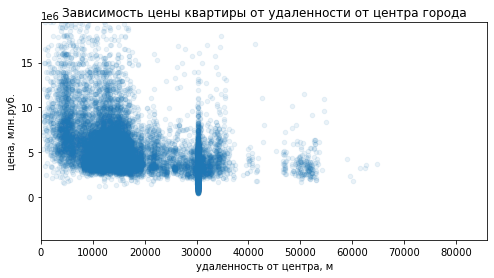

In [90]:
price_factor('city_center_distance', 'scatter', 8, 4, 'удаленность от центра, м','цена, млн.руб.', 'Зависимость цены квартиры от удаленности от центра города')

Удаленность от центра города вляет на цену квартиры, только если они расположены близко к центру (в пределах 15 км). По крайней мере дорогие квартиры раположены именно на такой удаленности. Дальше можно выделить своеобразное кольцо 15 - 35 км - вероятно, это окраины города. После 35 км. цена не зависит от расстояния от центра. 
По данной диаграмме нельзя сказать, что цена напрямую зависит от расстояния центра города. В центре города тоже нет четкой зависмости (нет зависимости что например в пределах 2 км - дороже, чем в пределах 6). Но сам факт расположения в центре увеличивает стоимость квартиры. 

Рассмотрим соотношение цены и этажа, на котором расположена квартира.
Для целей данного исследования ранее этажи были разбиты на категории: первый, средний (2-8), высокий (9-предпоследний) и последний.

Основания для выделения именно таких категорий, это потенциальные преимущества и недостатки, с которыми может столкнуться житель того или иного этажа:
* первый этаж - Минусы: близость окон к прохожим и машинам, близость к земле - может быть более холодно зимой, близость к подвальным коммуникациям - может быть сыро. Плюсы: можно легко выйти из дома, что может быть принципиально для маломобильных или пожилых людей.
* средние этажи - нейтральные: в случае отключения или отсутствия лифта можно подняться пешком, а так как не последний этаж - нет вопросов с крышей.
* высокие этажи - минусы: зависимость от лифта и электроснабжения, большое количество соседей (более высокие риски ремонтов, шума и т.д.), плюсы: возможен красивый вид из окна на город, длительный период, когда поступает солнечный свет, не беспокоят вопросы ни крыши, ни подвальных коммуникаций, удаленность от земли - потенциально меньше шума от дорог. 
* последний - минусы: жарко летом, очень критично состояние крыши, сложно подняться маломобильным людям, сложно что-то поднять если речь идет о домах без лифта (например, молодая мама не может на 5 этаж поднять и ребенка и коляску сама). плюсы: нет шума от соседей сверху.

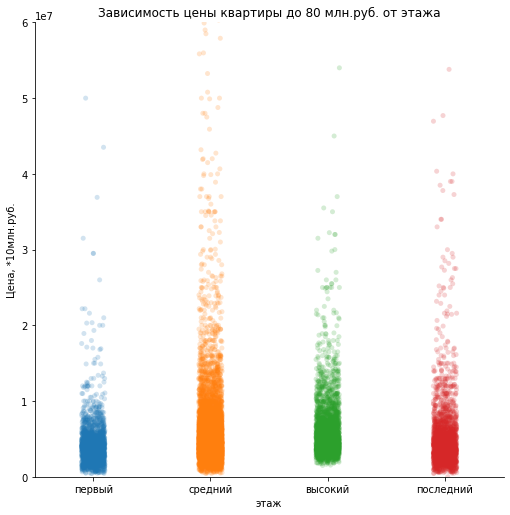

In [91]:
categories=['первый', 'средний', 'высокий', 'последний']
g=sns.catplot(x='floor_category', y='last_price', data=df_clean, alpha=0.2, order=categories, height=7)
g.set_axis_labels("этаж", "Цена, *10млн.руб.").set(ylim=(0, 60000000))
g.set(title='Зависимость цены квартиры до 80 млн.руб. от этажа')

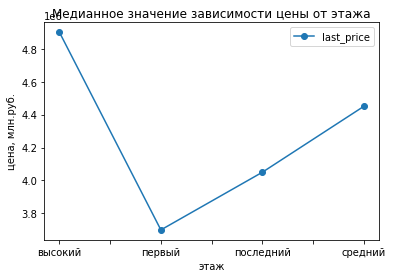

In [92]:
floor_price = df_clean.pivot_table(index='floor_category', values='last_price', aggfunc='median')
ax = floor_price.plot(style='o-')
ax.set(xlabel='этаж', ylabel='цена, млн.руб.', title='Медианное значение зависимости цены от этажа')
ax.ticklabel_format(axis='y', scilimits=(6,6))

График медианы показал нам, что медианна цены квартиры для высоких этажей ощутимо выше, чем цена за средние этажи. Это можно объяснить тем, что высокие этажи больше свойственны не для домов массовой советской застройки, а для так называемых новостроек. Традиционно, высокие дома строят ближе к центру деловой активности. То есть, скорее всего высотные здания расположены близко к центру, а значит это цена не столько за этаж, сколько за расположение. 

Посмотрим как изменились цены на квартиры по годам. Построим график медианного значения по цене.

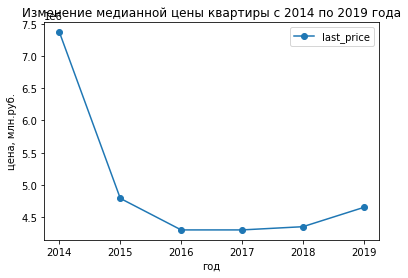

In [93]:
year_price = df_clean.pivot_table(index='year_exposition', values='last_price', aggfunc='median')
ax = year_price.plot(style='o-')
ax.set(xlabel='год', ylabel='цена, млн.руб.', title='Изменение медианной цены квартиры с 2014 по 2019 года')
ax.ticklabel_format(axis='y', scilimits=(6,6))

Пик цены был в 2014 году, который за год (с 2014 по 2015) резко снизился примерно на 30%. И до 2019 года медианное значение цены остается на уровне 2015 года.

Изучим действителен ли такой тренд для цены за 1 квадратный метр.

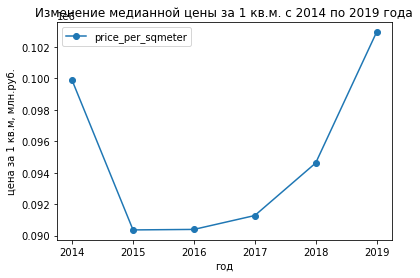

In [94]:
year_price_per_meter = df_clean.pivot_table(index='year_exposition', values='price_per_sqmeter', aggfunc='median')
ax = year_price_per_meter.plot(style='o-')
ax.set(xlabel='год', ylabel='цена за 1 кв.м, млн.руб.', title='Изменение медианной цены за 1 кв.м. с 2014 по 2019 года')
ax.ticklabel_format(axis='y', scilimits=(6,6))

Пик стоимости в 2014 году и резкое к 2015 году - аналогичны, но вот только с 2015 до 2019 годов шел уверенный рост стоимости квадратного метра. И уровень 2019 года соответсвует 2014 (самому пиковому).

Такая разность данных может говорить о следующих тенденциях: люди стали приобретать квартиры меньшей площади (более низкая общая цена, при высокой цене на квадратный метр), но, возможно лучшего качества (лучшего расположения или более эффективной планировки).

Может ли месяц размещения объявления повлиять на цену квартиры?

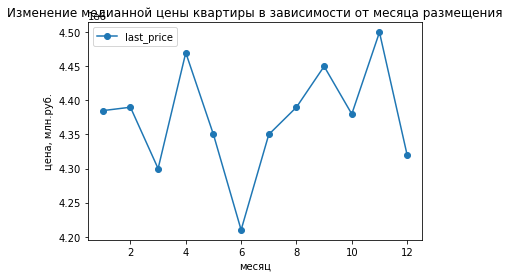

In [95]:
month_price = df_clean.pivot_table(index='month_exposition', values='last_price', aggfunc='median')
ax = month_price.plot(style='o-')
ax.set(xlabel='месяц', ylabel='цена, млн.руб.', title='Изменение медианной цены квартиры в зависимости от месяца размещения')
ax.ticklabel_format(axis='y', scilimits=(6,6))

Диаграмма медианного значения стоимости квартиры, по месяцам отражает, что наибольшую цену имеют квартиры в апреле, а наименьшую - в июне.
Это объяснимо тем, что Июнь - период начала отпусков, снижение деловой активности, поэтому и такое снижение цены. 

Построим диаграмму стоимости квартиры от дня недели. 

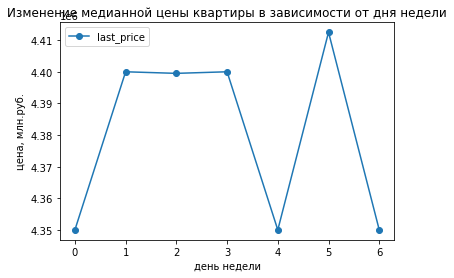

In [96]:
weekday_price = df_clean.pivot_table(index='weekday_exposition', values='last_price', aggfunc='median')
ax = weekday_price.plot(style='o-')
ax.set(xlabel='день недели', ylabel='цена, млн.руб.', title='Изменение медианной цены квартиры в зависимости от дня недели')
ax.ticklabel_format(axis='y', scilimits=(6,6))

Не смотря на то, что наибольшая цена во вторник, а к выходным снижается, считаю эту информацию малоценной. Так как в данном случае речь идет о дне недели, когда квартира выставлена на продажу. Так как средня продажа занимает 89 дней, не пренципиально какой день недели будет в сам момент сделки.

Интересно проследить есть ли зависимость между ценой квартиры и скоростью ее продажи. Построим соответсвующую диаграмму.

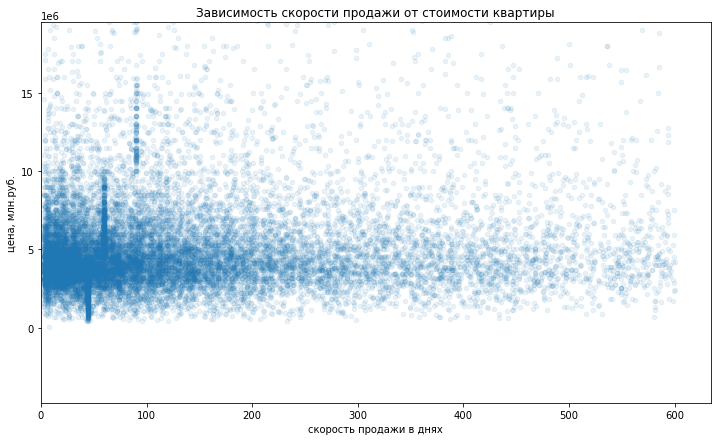

In [97]:
price_factor('days_exposition', 'scatter', 12, 7, 'скорость продажи в днях','цена, млн.руб.', 'Зависимость скорости продажи от стоимости квартиры')

Согласно полученной диаграмме, принцип (чем дешевле - тем быстрее продастся) более действителен для некоторых квартир до 7.5 млн.рублей. Однако в большинстве случаев низкая цена не является гарантией быстрой продажи. 

In [98]:
df_clean_corr = df_clean.corr()

<AxesSubplot:>

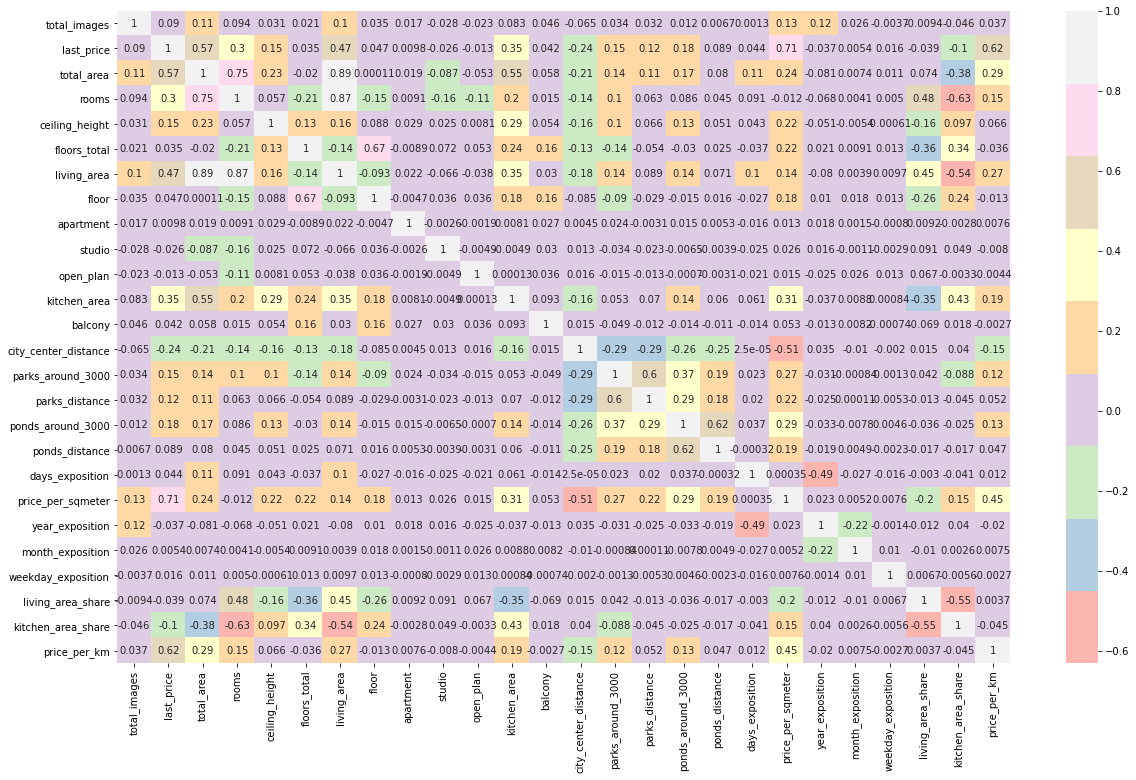

In [99]:
plt.figure(figsize=(20, 12))
sns.heatmap(df_clean_corr, vmax=1, annot=True, cmap='Pastel1')

Выделим элементы с максимальным коэффициентом корреляции - максимальной взаимозависимостью:
* Жилая площадь напрямую взаимосвязана с общей площадью и количеством комнат (0.87)
* количество комнат плотно связано с общей площадью (0.75)
* цена зависит от общей площади (0.57)
* в обратном порядке подтверждена взаимосвязь и жилой площади и площади кухни (-0.54) и доли площади кухни и комнат (-0.63)

__Самые популярные населенные пункты__<a id='bullet_8'></a>

Выявим 10 населенных пунктов, с самым большим количеством объявлений, посчитаем медианное значение цены за 1 кв.метр площади.

In [100]:
ten_localities = df_clean.pivot_table(index='locality_name', values = 'price_per_sqmeter', aggfunc=('count', 'mean'))
ten_localities = ten_localities.sort_values(by='count', ascending=False)
ten_localities = ten_localities.head(10)
ten_localities

,count,mean
locality_name,,
Санкт-Петербург,11833.0,109400.684780
Мурино,529.0,85853.158790
Кудрово,417.0,94662.352518
Шушары,393.0,77941.893130
Всеволожск,314.0,68573.436306
Парголово,293.0,89300.361775
Колпино,291.0,74827.271478
Пушкин,277.0,100824.916968
Гатчина,246.0,68046.044715


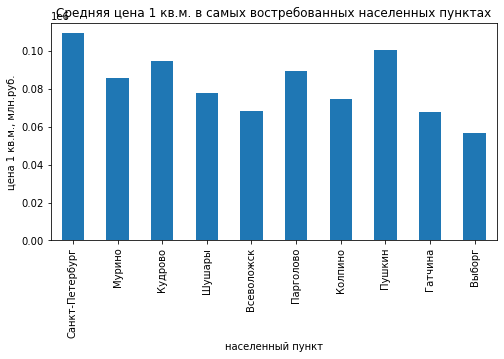

In [101]:
ax = ten_localities['mean'].plot(x='locality_name', y ='mean', kind='bar', figsize=(8,4))
ax.set(xlabel='населенный пункт', ylabel='цена 1 кв.м., млн.руб.', title='Средняя цена 1 кв.м. в самых востребованных населенных пунктах')
ax.ticklabel_format(axis='y', scilimits=(6,6))

Самая ценная недвижимость (из 10 самых популярных населенных пунктов) находится в Санкт-петербурге - в среднем 113 593 рублей за 1 кв.метр. Самая низкая цена за квадратный метр (из популярных локаций) - в Выборге - в среднем 58 096 рублей за квадратный метр. 

__Определим какие конкретно локации можно считать центром Санкт-Петербурга__<a id='bullet_9'></a>

Сделаем выборку объявлений по санкт-Петрбургу, и построим диаграмму зависимости цены квартиры от расстояния до центра города.

In [102]:
spb_center = df_clean.loc[df_clean['locality_name'] == 'Санкт-Петербург']
spb_center.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,...,ponds_distance,days_exposition,price_per_sqmeter,year_exposition,month_exposition,weekday_exposition,living_area_share,kitchen_area_share,floor_category,price_per_km
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,574,558.0,92785,2015,8,3,0.61,0.15,средний,372927
3,0,64900000,159.0,2015-07-24,3,2.65,14,45.0,9,False,...,234,424.0,408176,2015,7,4,0.28,0.06,высокий,9544117
9,18,5400000,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,0,289.0,88524,2017,2,6,0.71,0.11,средний,359808
10,5,5050000,39.6,2017-11-16,1,2.67,12,20.3,3,False,...,553,137.0,127525,2017,11,3,0.51,0.21,средний,363885
15,16,4650000,39.0,2017-11-18,1,2.65,14,20.5,5,False,...,296,19.0,119230,2017,11,5,0.53,0.19,средний,326109


In [103]:
spb_center['city_center_distance'] = spb_center['city_center_distance']/1000

In [104]:
spb_center['city_center_distance'] = spb_center['city_center_distance'].astype('int')

In [105]:
spb_center['city_center_distance'].head()

2     13
3      6
9     15
10    13
15    14
Name: city_center_distance, dtype: int32

In [106]:
spb_center_km = spb_center.pivot_table(index = 'city_center_distance', values = 'last_price', aggfunc='mean')

In [107]:
spb_center_km.head(10)

,last_price
city_center_distance,
0,2.477051e+07
1,1.408456e+07
2,1.423905e+07
3,1.375608e+07
4,1.149486e+07
5,1.243559e+07
6,1.049763e+07
7,1.094513e+07
8,7.009891e+06


[Text(0.5, 0, 'удаленность от центра, км'),
 Text(0, 0.5, 'цена, млн.руб.'),
 Text(0.5, 1.0, 'Зависимость цены от удаленности от центра')]

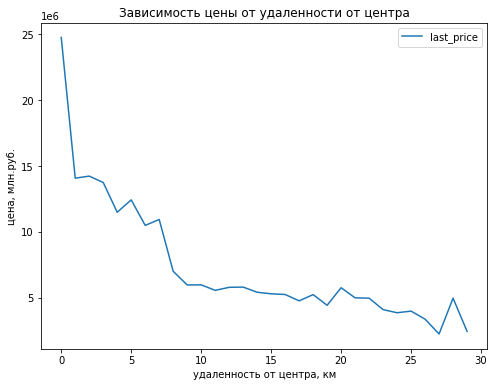

In [108]:
ax = spb_center_km.plot(figsize=(8, 6))
ax.ticklabel_format(axis='y', scilimits=(6,6))
ax.set(xlabel='удаленность от центра, км', ylabel='цена, млн.руб.', title='Зависимость цены от удаленности от центра')

Центр Санкт-Петербурга - это квартиры расположенные в радиусе 7 километров от понятия 'центр". 

Изучим соответсвуют ли тренды всей выборки трендам квартир, расположенных в центре санкт-Петербурга.
Для начала посчитаем количество объявлений. Таких объявлений 1701.

In [109]:
spb_very_center = df_clean.query('locality_name == "Санкт-Петербург" and city_center_distance <= 7000')
len(spb_very_center)

1701

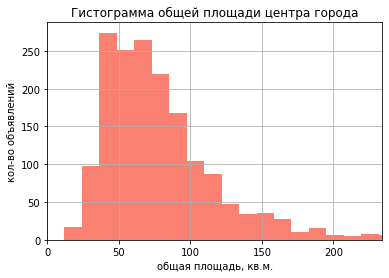

In [110]:
frequency (spb_very_center['total_area'], 'общая площадь, кв.м.', 'кол-во объявлений', 'Гистограмма общей площади центра города', 40, False, "salmon")

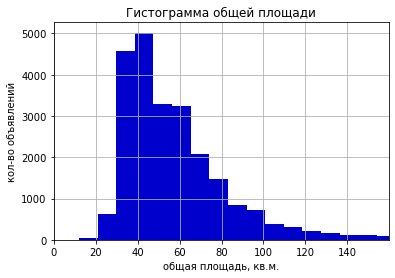

In [111]:
frequency (df['total_area'], 'общая площадь, кв.м.', 'кол-во объявлений', 'Гистограмма общей площади', 100, False, "mediumblue")

Гистограмма общей площади демонстрирует, что наиболее популярные квартиры площадью от 40 до 70 кв.м. И эти значения близки к медианному значению по всей выборке. Ранее мы рассчитали медиану = 52 кв.м.

Изучим а как же меняется стоимость квартир в центре города.

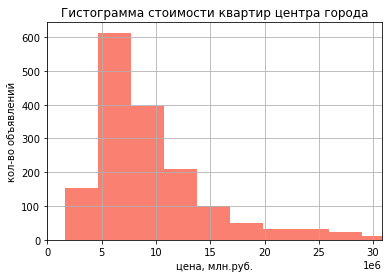

In [112]:
frequency (spb_very_center['last_price'], 'цена, млн.руб.', 'кол-во объявлений', 'Гистограмма стоимости квартир центра города', 250, True, "salmon")

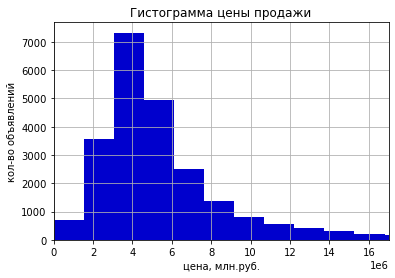

In [113]:
frequency (df['last_price'], 'цена, млн.руб.', 'кол-во объявлений', 'Гистограмма цены продажи', 500, True, "mediumblue")

Большинство квартир по цене около 7 млн.рублей. Общая выборка у нас была представлена цифрой 3 - 5 млн. рублей. Общий вывод, что квартиры в центре не просторнее, но дороже.

Изучим количество комнат в центре.

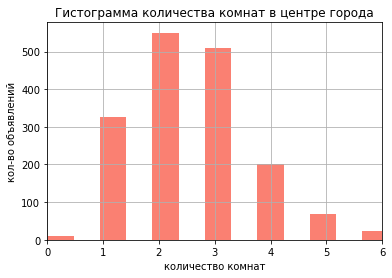

In [114]:
frequency (spb_very_center['rooms'], 'количество комнат', 'кол-во объявлений', 'Гистограмма количества комнат в центре города', 17, False, "salmon")

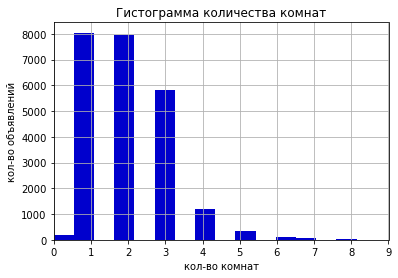

In [115]:
frequency (df['rooms'], 'кол-во комнат', 'кол-во объявлений', 'Гистограмма количества комнат', 35, False, "mediumblue")

В отношении количества комнат, квартиры в центре города не только больше по площади, но и преимущественно имеют больше комнат - самые распростараненные 2-х и 3-комнатные квартиры. В то время как в общей выборке лидерство за 1- и 2-комнатными.

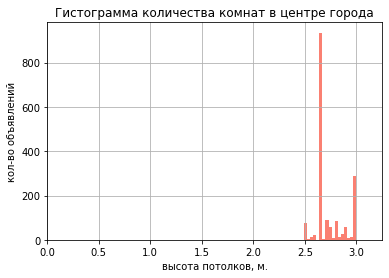

In [116]:
frequency (spb_very_center['ceiling_height'], 'высота потолков, м.', 'кол-во объявлений', 'Гистограмма количества комнат в центре города', 20, False, "salmon")

Высота потолков в центральных квартирах в общем смысле такая же - 2,65-2,7 м. Но вариантов с высокми потолками 3 метра и выше больше, чем в общей выборке, относительно числа всех объявлений

Изучим как цена квартиры в центре города зависит от показателей: количество комнат, этаж, расстояние до центра, год, месяц. Для этого построим соответсвующие диаграммы (график оранжевого цвета), и добавим для удобного сравнения аналогичную информацию по всей выборке (графики синего цвета)

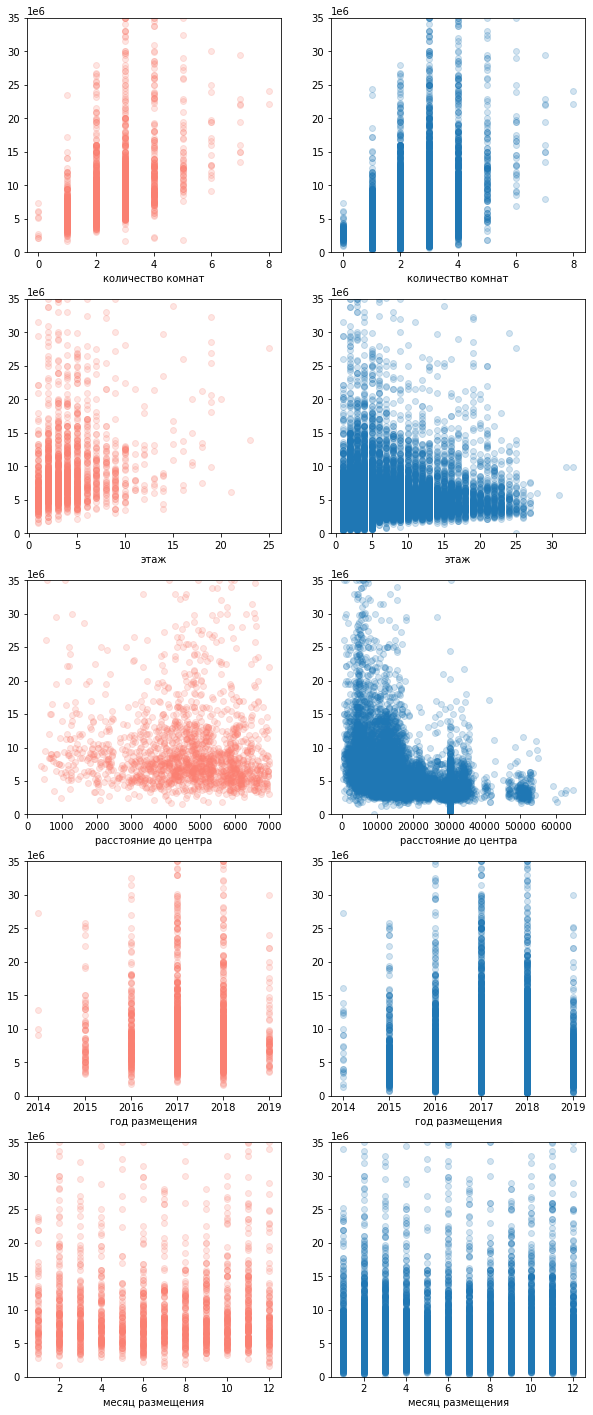

In [117]:
a = [0, 1, 2, 3, 4]
b = ['rooms', 'floor', 'city_center_distance', 'year_exposition', 'month_exposition']
d = ['количество комнат','этаж', 'расстояние до центра', 'год размещения', 'месяц размещения']
fig, axs = plt.subplots(5, 2, figsize=(10, 25))
for a, b, d in zip(a, b, d):
    axs[a, 0].scatter(spb_very_center[b], spb_very_center['last_price'], alpha=0.2, color='salmon')
    axs[a, 0].set_xlabel(d)
    axs[a, 0].set_ylim(0, 35000000)
    axs[a, 0].ticklabel_format(axis='y', scilimits=(6,6))
    axs[a, 1].scatter(df_clean[b], df_clean['last_price'], alpha=0.2)
    axs[a, 1].set_xlabel(d)
    axs[a, 1].set_ylim(0, 35000000)
    axs[a, 1].ticklabel_format(axis='y', scilimits=(6,6))
plt.show()

Количество комнат: распределение очень похоже на распределение по всей выборке. Однако, диаграмма показала нам нижний уровень стоимости квартиры в центре СПб, в то время как на общей выборке этого почти не видно.

Диаграмма этажности отражает что центр города характеризуется малоэтажными застройками, поэтому 8-9, а уж тем более более высокие этажи в центре города практически не встречаются.

Удаленность внутри центра города не влияет на цену - так как никакой зависимости на графике не просматривается

Цены по годам. Наиболее высокие цены и наибольшее разнообразие цен было в 2017 году, это же справедливо и для общей выборки.

Месяц размещения объявления не оказал значительного влияния на цену квартиры, лишь немногопрослеживается, что весной квартиры дешевле, чем в другие сезоны.

In [118]:
spb_center_corr = spb_very_center.corr()

<AxesSubplot:>

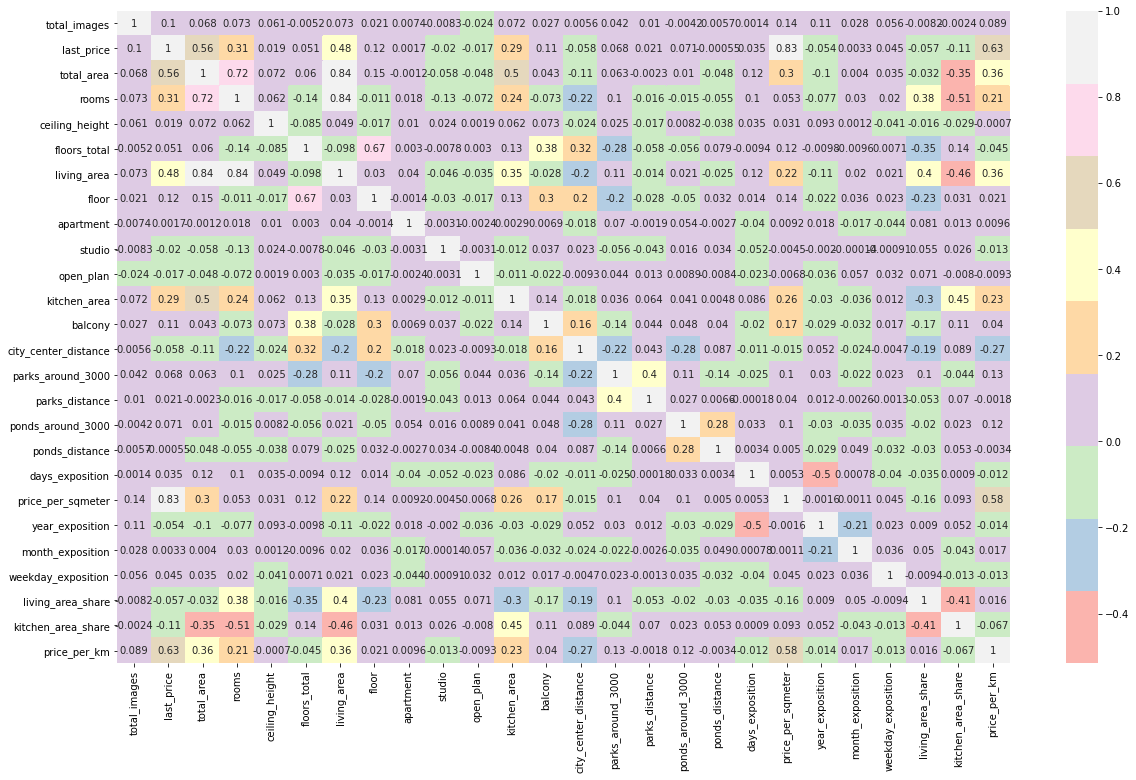

In [119]:
plt.figure(figsize=(20, 12))
sns.heatmap(spb_center_corr, vmax=1, annot=True, cmap='Pastel1')

В общем смысле принцип ценообразования на недвижимость в центре Санкт-Петербурга не сильно отличается от ценообразования в Ленинградской области. Да, действительно, в абсолютном выражении цены выше, нет демократичных предложений с небольшой площадью и низкими ценами, а есть 2 комнатные квартиры по 70 кв. метров в малоэтажной застройке в центре города. Но сами факторы и их взаимосвязь не меняются.

### Общий вывод

В качестве общего вывода, сформируем портрет самой удачной квартиры для продавца: 3-комнатная квартира площадью около 100 кв.м. на среднем этаже (3 или 4), расположенная в пределах 6 км от центра города. Цена такой квартиры может начинаться от 25 млн.рублей, и продастся за 3 - 6 месяцев.

Какую квартиру можно продать быстрее всего? Квартиру стоимостью до 7.5 млн рублей. Это может быть однокомнатная квартира на первом этаже в самом центре Санкт-Петербурга. Или например, 3-комнатную квартиру 80 кв.метров в Колпино. 

Какие квартиры самые дорогие и как долго они продаются? 4-5 комнатная квартира в центре Санкт-Петербурга, площадью 150-250 кв.метров с кухней 20 кв. метров. Стоить такая квартира будет около 175 млн.руб. и продаваться такая квартира может до 300 дней (до 1 года). 

Ну а если клиент хочет купить квартиру по оптимальной цене, то с каким же параметры сильно повлияют на стоимость квартиры, а в каких можно не идти на компромисс? Если хочется купить квартиру по оптимальной цене, то не нужно смотреть квартиры близко в центру (там и цены выше, и площади большие), но если выбирать квартиру на расстоянии 15 км и 100 км - разницы в цене не будет. Если нужно сэкономить, то можно выбрать квартиру на первом этаже, и желательно приобретать квартиру в августе (это те самые квартиры по низким ценам, объявления о которых разместили в июне, но продавались они около 80 дней). Очень хороший показатель - это стоимость квадратного метра - если хочется сэкономить, то Выборг - будет хорошим вариантом: широкий выбор объявлений по низкой цене за 1 кв. метр. 